In [1]:
import sys
sys.path.append('../')
from read_data_functions import *
from plot_functions import *
from calculations import *
plt.style.use('../Style.mplstyle')
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # suppress warnings

In [2]:
path = '../../../Data/2025/'
AMS_paths = ['250820_sabinene_O3_20C/', '250822_Sabinene_100ppb_0C/', '250825_Sabinene_100ppb_10C/', 
             '250826_Sabinene_100ppb_neg10C/', '250828_b-pinene_100ppb_20C/']

AMS = {}
for AMS_path in AMS_paths:
    df = import_txt(f'{path}{AMS_path}AMS/', '', 't_series', '%d-%m-%Y %H:%M:%S', 0)
    name = AMS_path.split('_')[0]
    AMS[name] = df

print(AMS['250822'].keys())

Index(['t_series', 'HROrg_M_all', 'HRNO3_M_all', 'HRSO4_M_all', 'HRNH4_M_all',
       'HRChl_M_all', 'Ratio_H_C_all_IA', 'Ratio_O_C_all_IA',
       'familyCHN_M_all', 'familyCHO1_M_all', 'familyCHO1N_M_all',
       'familyCH_M_all', 'MSSM_all_HROrg43', 'MSSM_all_HROrg44', 'Time'],
      dtype='object')


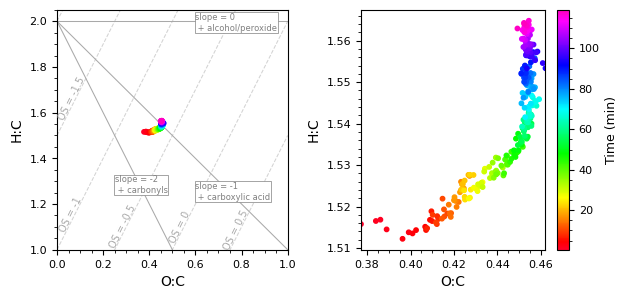

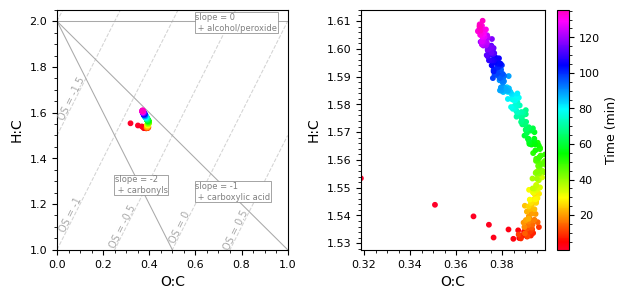

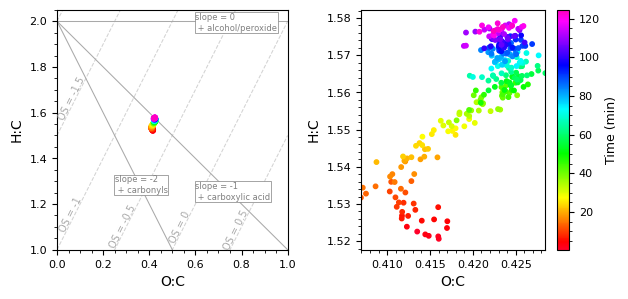

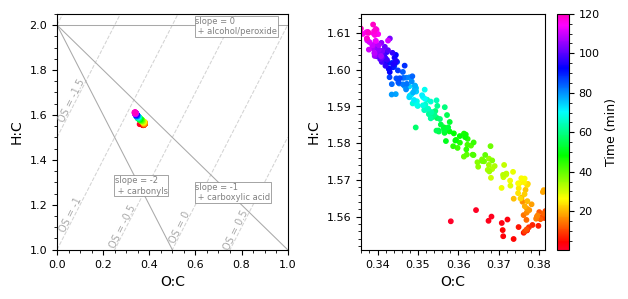

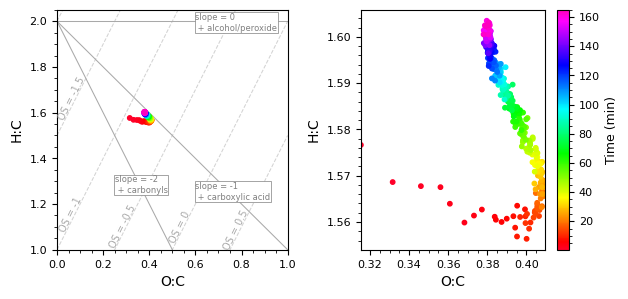

In [3]:
timestamps = [['2025-08-20 10:10', '2025-08-20 12:25'],
              ['2025-08-22 10:20', '2025-08-22 12:48'],
              ['2025-08-25 09:27', '2025-08-25 11:37'],
              ['2025-08-26 09:36', '2025-08-26 11:42'],
              ['2025-08-28 09:07', '2025-08-28 12:00']]

for key, time in zip(AMS.keys(), timestamps):
    fig, ax = vanKrevelen_ts(AMS[key], ['Ratio_H_C_all_IA', 'Ratio_O_C_all_IA'], time, 0.5)
    fig.tight_layout(pad = 0.75)
    fig.savefig(f'vanKrevelen_{key}.jpg', dpi = 600)

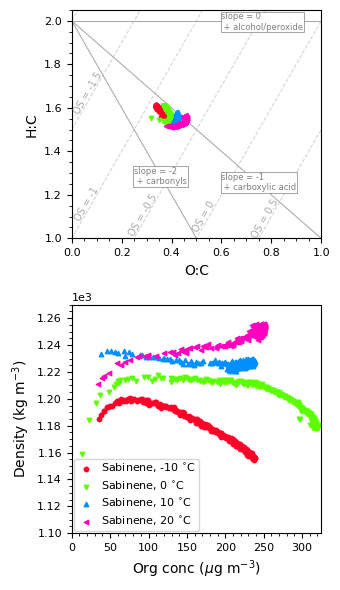

In [4]:
timestamps = [['2025-08-26 09:36', '2025-08-26 11:42'],
              ['2025-08-22 10:20', '2025-08-22 12:48'],
              ['2025-08-25 09:27', '2025-08-25 11:37'],
              ['2025-08-20 10:10', '2025-08-20 12:25']]

fig, ax = plt.subplots(2, 1, figsize = (3.5, 6))
vanKrevelen_multi_exp(ax, AMS, ['250826', '250822', '250825', '250820'], ['Ratio_H_C_all_IA', 'Ratio_O_C_all_IA', 'HROrg_M_all'], timestamps, 
                      ['Sabinene, -10 $^{\circ}$C', 'Sabinene, 0 $^{\circ}$C', 'Sabinene, 10 $^{\circ}$C', 'Sabinene, 20 $^{\circ}$C'])
fig.tight_layout()
fig.savefig('vanKrevelen_sabinene.jpg', dpi = 600)